# Gesture Recognition - Srinivas & Sameer
In this group project, we are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
import cv2
import matplotlib.pyplot as plt
#% matplotlib inline

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

In [5]:
project_folder='datasets/Project_data'

##### Plotting

In [6]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
class ModelBuilder(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=64,image_width=64):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Sample Model

In [8]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = 'adam' #write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())
        
        return model

In [9]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=64,image_width=64)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=40,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 64, 64, 16)    1312      
                                                                 
 activation (Activation)     (None, 30, 64, 64, 16)    0         
                                                                 
 batch_normalization (BatchN  (None, 30, 64, 64, 16)   64        
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 32, 32, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 32, 32, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 15, 32, 32, 32)    0

2023-03-14 11:16:36.751262: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-03-14 11:16:36.751323: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


##### Sample Cropping

In [10]:
#test_generator=ModelConv3D1()
#test_generator.initialize_path(project_folder)
#test_generator.initialize_image_properties(image_height=160,image_width=160)
#test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

#g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
#batch_data, batch_labels=next(g)
#fig, axes = plt.subplots(nrows=1, ncols=2)
#axes[0].imshow(batch_data[0,15,:,:,:])   
#axes[1].imshow(batch_data[3,15,:,:,:])   

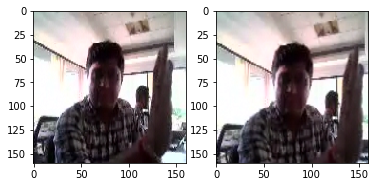

## Experimenting with Image resolution, number of frames to use and batch_size

In [11]:
#conv_3d1.train_model(conv_3d1_model)

### We had hit the limit on memory resources with image resolution of 160x160 with 30 frames and batch_size of 40...we get the below error

ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

In [12]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109524011612 Gigs


##### So lets trade-off between these parameters

##### Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [13]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=64,image_width=64)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 64, 64, 16)    1312      
                                                                 
 activation_4 (Activation)   (None, 16, 64, 64, 16)    0         
                                                                 
 batch_normalization_6 (Batc  (None, 16, 64, 64, 16)   64        
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 8, 32, 32, 16)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 8, 32, 32, 32)     4128      
                                                                 
 activation_5 (Activation)   (None, 8, 32, 32, 32)    

2023-03-14 11:16:41.159014: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 1.6216 - categorical_accuracy: 0.4027
Epoch 00001: saving model to model_init_2023-03-1411_16_37.177114/model-00001-1.62159-0.40271-2.00763-0.21000.h5
23/23 [==============================] - 44s 2s/step - loss: 1.6216 - categorical_accuracy: 0.4027 - val_loss: 2.0076 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/3
23/23 [==============================] - ETA: 0s - loss: 1.1387 - categorical_accuracy: 0.5475
Epoch 00002: saving model to model_init_2023-03-1411_16_37.177114/model-00002-1.13870-0.54751-2.78273-0.21000.h5
23/23 [==============================] - 43s 2s/step - loss: 1.1387 - categorical_accuracy: 0.5475 - val_loss: 2.7827 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/3
23/23 [==============================] - ETA: 0s - loss: 1.0610 - categorical_accuracy: 0.5852
Epoch 00003: saving model to model_init_2023-03-1411_16_37.177114/model-00003-1.06099-0.58522-3.25664-0.15000.h5
23/23 [=================

In [14]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=64,image_width=64)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 64, 64, 16)    1312      
                                                                 
 activation_8 (Activation)   (None, 30, 64, 64, 16)    0         
                                                                 
 batch_normalization_12 (Bat  (None, 30, 64, 64, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 32, 32, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 15, 32, 32, 32)    4128      
                                                                 
 activation_9 (Activation)   (None, 15, 32, 32, 32)   

In [15]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=64,image_width=64)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 30, 64, 64, 16)    1312      
                                                                 
 activation_12 (Activation)  (None, 30, 64, 64, 16)    0         
                                                                 
 batch_normalization_18 (Bat  (None, 30, 64, 64, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 15, 32, 32, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 15, 32, 32, 32)    4128      
                                                                 
 activation_13 (Activation)  (None, 15, 32, 32, 32)   

In [16]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=64,image_width=64)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 16, 64, 64, 16)    1312      
                                                                 
 activation_16 (Activation)  (None, 16, 64, 64, 16)    0         
                                                                 
 batch_normalization_24 (Bat  (None, 16, 64, 64, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 8, 32, 32, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 8, 32, 32, 32)     4128      
                                                                 
 activation_17 (Activation)  (None, 8, 32, 32, 32)    

In [17]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=64,image_width=64)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=80,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 16, 64, 64, 16)    1312      
                                                                 
 activation_20 (Activation)  (None, 16, 64, 64, 16)    0         
                                                                 
 batch_normalization_30 (Bat  (None, 16, 64, 64, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 8, 32, 32, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 8, 32, 32, 32)     4128      
                                                                 
 activation_21 (Activation)  (None, 8, 32, 32, 32)    

In [18]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=64,image_width=64)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 30, 64, 64, 16)    1312      
                                                                 
 activation_24 (Activation)  (None, 30, 64, 64, 16)    0         
                                                                 
 batch_normalization_36 (Bat  (None, 30, 64, 64, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 15, 32, 32, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 15, 32, 32, 32)    4128      
                                                                 
 activation_25 (Activation)  (None, 15, 32, 32, 32)   

In [19]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=64,image_width=64)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 16, 64, 64, 16)    1312      
                                                                 
 activation_28 (Activation)  (None, 16, 64, 64, 16)    0         
                                                                 
 batch_normalization_42 (Bat  (None, 16, 64, 64, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 8, 32, 32, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (None, 8, 32, 32, 32)     4128      
                                                                 
 activation_29 (Activation)  (None, 8, 32, 32, 32)    

In [20]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=64,image_width=64)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 16, 64, 64, 16)    1312      
                                                                 
 activation_32 (Activation)  (None, 16, 64, 64, 16)    0         
                                                                 
 batch_normalization_48 (Bat  (None, 16, 64, 64, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 8, 32, 32, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_33 (Conv3D)          (None, 8, 32, 32, 32)     4128      
                                                                 
 activation_33 (Activation)  (None, 8, 32, 32, 32)    

In [21]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=64,image_width=64)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_36 (Conv3D)          (None, 16, 64, 64, 16)    1312      
                                                                 
 activation_36 (Activation)  (None, 16, 64, 64, 16)    0         
                                                                 
 batch_normalization_54 (Bat  (None, 16, 64, 64, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_36 (MaxPoolin  (None, 8, 32, 32, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_37 (Conv3D)          (None, 8, 32, 32, 32)     4128      
                                                                 
 activation_37 (Activation)  (None, 8, 32, 32, 32)    

In [22]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=64,image_width=64)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 30, 64, 64, 16)    1312      
                                                                 
 activation_40 (Activation)  (None, 30, 64, 64, 16)    0         
                                                                 
 batch_normalization_60 (Bat  (None, 30, 64, 64, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_40 (MaxPoolin  (None, 15, 32, 32, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_41 (Conv3D)          (None, 15, 32, 32, 32)    4128      
                                                                 
 activation_41 (Activation)  (None, 15, 32, 32, 32)  

In [23]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=64,image_width=64)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_44 (Conv3D)          (None, 30, 64, 64, 16)    1312      
                                                                 
 activation_44 (Activation)  (None, 30, 64, 64, 16)    0         
                                                                 
 batch_normalization_66 (Bat  (None, 30, 64, 64, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_44 (MaxPoolin  (None, 15, 32, 32, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_45 (Conv3D)          (None, 15, 32, 32, 32)    4128      
                                                                 
 activation_45 (Activation)  (None, 15, 32, 32, 32)  

In [24]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=64,image_width=64)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_48 (Conv3D)          (None, 16, 64, 64, 16)    1312      
                                                                 
 activation_48 (Activation)  (None, 16, 64, 64, 16)    0         
                                                                 
 batch_normalization_72 (Bat  (None, 16, 64, 64, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_48 (MaxPoolin  (None, 8, 32, 32, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_49 (Conv3D)          (None, 8, 32, 32, 32)     4128      
                                                                 
 activation_49 (Activation)  (None, 8, 32, 32, 32)   

In [25]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=64,image_width=64)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_52 (Conv3D)          (None, 16, 64, 64, 16)    1312      
                                                                 
 activation_52 (Activation)  (None, 16, 64, 64, 16)    0         
                                                                 
 batch_normalization_78 (Bat  (None, 16, 64, 64, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_52 (MaxPoolin  (None, 8, 32, 32, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_53 (Conv3D)          (None, 8, 32, 32, 32)     4128      
                                                                 
 activation_53 (Activation)  (None, 8, 32, 32, 32)   

##### As we see from the above experiments image resolution and number of frames in sequence have significant impact on training time compared to batch_size

##### Hence experimentations are carried with batch size fixed around 15-40 and resolution of image 64X64 and number of image per sequence based on the device memory constraints . Models are designed such that their memory foot print is less than 50 MB which corresponds to 4.3 million parameters assuming the datatype size of parameters to be 12 bytes

# Model 1 - Base Model - No Data Augmentation Batch Size 40 and Epoch 15

In [28]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = 'adam' #write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())
        return model

In [29]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=64,image_width=64)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_60 (Conv3D)          (None, 20, 64, 64, 16)    1312      
                                                                 
 activation_60 (Activation)  (None, 20, 64, 64, 16)    0         
                                                                 
 batch_normalization_90 (Bat  (None, 20, 64, 64, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_60 (MaxPoolin  (None, 10, 32, 32, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_61 (Conv3D)          (None, 10, 32, 32, 32)    13856     
                                                                 
 activation_61 (Activation)  (None, 10, 32, 32, 32)  

In [30]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 428933
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.6638 - categorical_accuracy: 0.3891
Epoch 00001: saving model to model_init_2023-03-1411_53_13.947855/model-00001-1.66376-0.38914-1.59343-0.22000.h5
17/17 [==============================] - 55s 3s/step - loss: 1.6638 - categorical_accuracy: 0.3891 - val_loss: 1.5934 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 1.1935 - categorical_accuracy: 0.5294
Epoch 00002: saving model to model_init_2023-03-1411_53_13.947855/model-00002-1.19349-0.52941-1.85701-0.32000.h5
17/17 [==============================] - 54s 3s/step - loss: 1.1935 - categorical_accuracy: 0.5294 - val_loss: 1.8570 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.7749 - categorical_accuracy: 0.7149
Epoch 00003: saving model to model_init_2023-03-1411_53_13.947855/model-00003-0.77492-0.71493-2.72815-0

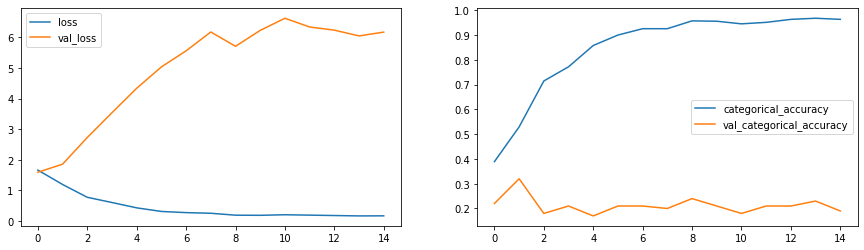

In [31]:
plot(history_model1)

##### Model is clearly overfitting. So we need to do data augmentation

# Model 2 - Augment Data , (3,3,3) filter & 64X64 image resolution

In [32]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=64,image_width=64)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_64 (Conv3D)          (None, 20, 64, 64, 16)    1312      
                                                                 
 activation_64 (Activation)  (None, 20, 64, 64, 16)    0         
                                                                 
 batch_normalization_96 (Bat  (None, 20, 64, 64, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_64 (MaxPoolin  (None, 10, 32, 32, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_65 (Conv3D)          (None, 10, 32, 32, 32)    13856     
                                                                 
 activation_65 (Activation)  (None, 10, 32, 32, 32)  

In [33]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 886469
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.0344 - categorical_accuracy: 0.3446
Epoch 00001: saving model to model_init_2023-03-1412_09_48.633138/model-00001-2.03438-0.34465-2.19786-0.17000.h5
34/34 [==============================] - 101s 3s/step - loss: 2.0344 - categorical_accuracy: 0.3446 - val_loss: 2.1979 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5146 - categorical_accuracy: 0.4864
Epoch 00002: saving model to model_init_2023-03-1412_09_48.633138/model-00002-1.51464-0.48643-4.89843-0.12000.h5
34/34 [==============================] - 91s 3s/step - loss: 1.5146 - categorical_accuracy: 0.4864 - val_loss: 4.8984 - val_categorical_accuracy: 0.1200 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.2902 - categorical_accuracy: 0.5558
Epoch 00003: saving model to model_init_2023-03-1412_09_48.633138/model-00003-1.29018-0.55581-6.42169-

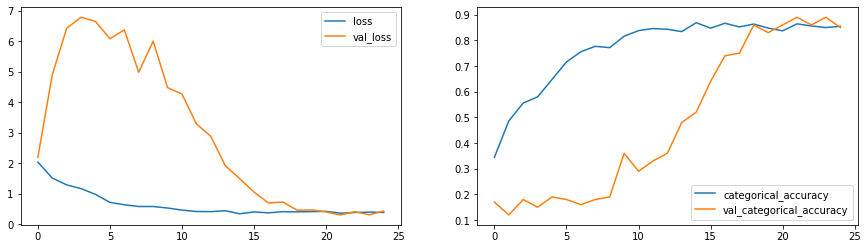

In [34]:
plot(history_model2)

##### Model is not overfitting and we get a best validation accuracy of 85% and training accuracy of 85%. Next we will try to reduce the filter size and image resolution and see if get better results. 

# Model 3 - Reduce filter size to (2,2,2) 

In [35]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = 'adam' #write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())
        return model

In [36]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=64,image_width=64)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_68 (Conv3D)          (None, 16, 64, 64, 16)    400       
                                                                 
 activation_68 (Activation)  (None, 16, 64, 64, 16)    0         
                                                                 
 batch_normalization_102 (Ba  (None, 16, 64, 64, 16)   64        
 tchNormalization)                                               
                                                                 
 max_pooling3d_68 (MaxPoolin  (None, 8, 32, 32, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_69 (Conv3D)          (None, 8, 32, 32, 32)     4128      
                                                                 
 activation_69 (Activation)  (None, 8, 32, 32, 32)   

In [37]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 681269
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.9776 - categorical_accuracy: 0.3567
Epoch 00001: saving model to model_init_2023-03-1413_02_08.786450/model-00001-1.97764-0.35671-2.27275-0.16000.h5
23/23 [==============================] - 72s 3s/step - loss: 1.9776 - categorical_accuracy: 0.3567 - val_loss: 2.2728 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.4153 - categorical_accuracy: 0.4879
Epoch 00002: saving model to model_init_2023-03-1413_02_08.786450/model-00002-1.41535-0.48793-4.83372-0.12000.h5
23/23 [==============================] - 72s 3s/step - loss: 1.4153 - categorical_accuracy: 0.4879 - val_loss: 4.8337 - val_categorical_accuracy: 0.1200 - lr: 0.0010
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.1132 - categorical_accuracy: 0.5958
Epoch 00003: saving model to model_init_2023-03-1413_02_08.786450/model-00003-1.11317-0.59578-5.90640-0

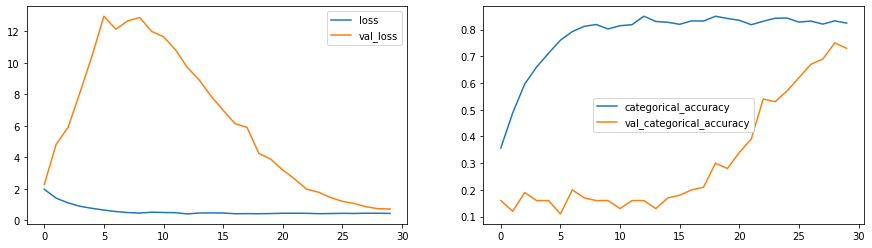

In [38]:
plot(history_model3)

##### Model has a  best validation accuracy of 82% and training accuracy of 73% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers

# Model 4 - Adding more layers

In [39]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = 'adam' #write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())
        return model

In [40]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=64,image_width=64)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_72 (Conv3D)          (None, 16, 64, 64, 16)    1312      
                                                                 
 activation_72 (Activation)  (None, 16, 64, 64, 16)    0         
                                                                 
 batch_normalization_108 (Ba  (None, 16, 64, 64, 16)   64        
 tchNormalization)                                               
                                                                 
 conv3d_73 (Conv3D)          (None, 16, 64, 64, 16)    6928      
                                                                 
 activation_73 (Activation)  (None, 16, 64, 64, 16)    0         
                                                                 
 batch_normalization_109 (Ba  (None, 16, 64, 64, 16)   64        
 tchNormalization)                                   

In [41]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 1475189
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.2323 - categorical_accuracy: 0.3122
Epoch 00001: saving model to model_init_2023-03-1413_43_02.765373/model-00001-2.23227-0.31222-1.84611-0.21000.h5
34/34 [==============================] - 77s 2s/step - loss: 2.2323 - categorical_accuracy: 0.3122 - val_loss: 1.8461 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.6979 - categorical_accuracy: 0.4231
Epoch 00002: saving model to model_init_2023-03-1413_43_02.765373/model-00002-1.69795-0.42308-3.39927-0.13000.h5
34/34 [==============================] - 72s 2s/step - loss: 1.6979 - categorical_accuracy: 0.4231 - val_loss: 3.3993 - val_categorical_accuracy: 0.1300 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.4743 - categorical_accuracy: 0.4940
Epoch 00003: saving model to model_init_2023-03-1413_43_02.765373/model-00003-1.47433-0.49397-3.78544-

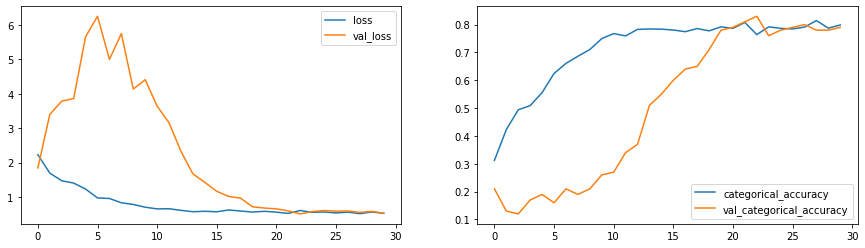

In [42]:
plot(history_model4)

#####  We got a best validation accuracy of 79% . Let's try adding dropouts at the convolution layers

# Model 5 Adding dropout at convolution layers

In [43]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = 'adam' #write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())
        return model

In [44]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=64,image_width=64)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=22)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_80 (Conv3D)          (None, 16, 64, 64, 16)    1312      
                                                                 
 activation_80 (Activation)  (None, 16, 64, 64, 16)    0         
                                                                 
 batch_normalization_118 (Ba  (None, 16, 64, 64, 16)   64        
 tchNormalization)                                               
                                                                 
 conv3d_81 (Conv3D)          (None, 16, 64, 64, 16)    6928      
                                                                 
 activation_81 (Activation)  (None, 16, 64, 64, 16)    0         
                                                                 
 batch_normalization_119 (Ba  (None, 16, 64, 64, 16)   64        
 tchNormalization)                                   

In [45]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 1475189
Epoch 1/22
34/34 [==============================] - ETA: 0s - loss: 1.8471 - categorical_accuracy: 0.3499
Epoch 00001: saving model to model_init_2023-03-1414_19_31.404483/model-00001-1.84708-0.34992-1.99778-0.16000.h5
34/34 [==============================] - 77s 2s/step - loss: 1.8471 - categorical_accuracy: 0.3499 - val_loss: 1.9978 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/22
33/34 [============================>.] - ETA: 2s - loss: 1.3776 - categorical_accuracy: 0.4833
Epoch 00002: saving model to model_init_2023-03-1414_19_31.404483/model-00002-1.38087-0.48115-2.43012-0.18000.h5
34/34 [==============================] - 77s 2s/step - loss: 1.3809 - categorical_accuracy: 0.4811 - val_loss: 2.4301 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/22
34/34 [==============================] - ETA: 0s - loss: 1.3294 - categorical_accuracy: 0.5219
Epoch 00003: saving model to model_init_2023-03-1414_19_31.404483/model-00003-1.32940-0.52187-3.02915-

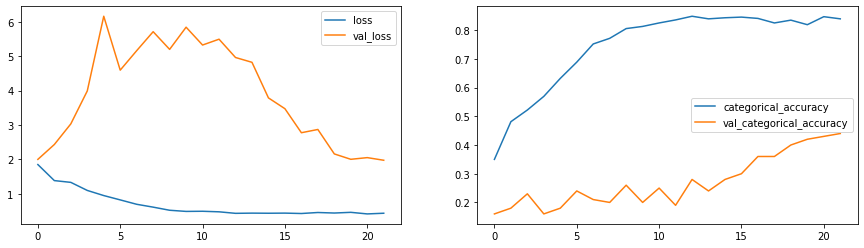

In [46]:
plot(history_model5)

##### Adding dropouts has further dropped validation accuracy as half of percentage as its not to learn  generalizable features

##### All models experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

# Model 6 - reducing the number of parameters

In [47]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = 'adam' #write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())
        return model

In [48]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=64,image_width=64)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_88 (Conv3D)          (None, 16, 64, 64, 16)    1312      
                                                                 
 activation_88 (Activation)  (None, 16, 64, 64, 16)    0         
                                                                 
 batch_normalization_128 (Ba  (None, 16, 64, 64, 16)   64        
 tchNormalization)                                               
                                                                 
 max_pooling3d_80 (MaxPoolin  (None, 8, 32, 32, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_89 (Conv3D)          (None, 8, 32, 32, 32)     4128      
                                                                 
 activation_89 (Activation)  (None, 8, 32, 32, 32)   

In [49]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 368965
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.6293 - categorical_accuracy: 0.3974
Epoch 00001: saving model to model_init_2023-03-1414_46_25.130645/model-00001-1.62928-0.39744-3.66551-0.16000.h5
34/34 [==============================] - 72s 2s/step - loss: 1.6293 - categorical_accuracy: 0.3974 - val_loss: 3.6655 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.0449 - categorical_accuracy: 0.6063
Epoch 00002: saving model to model_init_2023-03-1414_46_25.130645/model-00002-1.04489-0.60633-6.26231-0.14000.h5
34/34 [==============================] - 71s 2s/step - loss: 1.0449 - categorical_accuracy: 0.6063 - val_loss: 6.2623 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.8118 - categorical_accuracy: 0.6916
Epoch 00003: saving model to model_init_2023-03-1414_46_25.130645/model-00003-0.81175-0.69155-7.80173-0

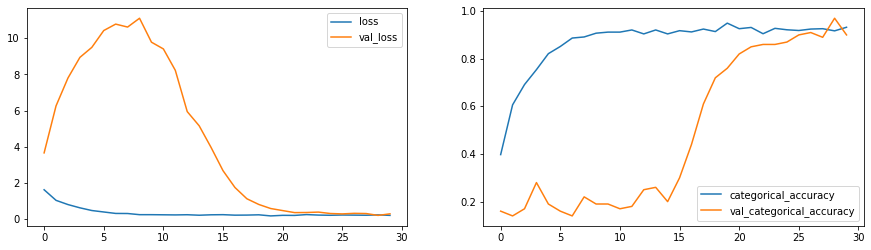

In [50]:
plot(history_model6)

###### For the above low memory foot print model the best validation accuracy of 90%

# Model 7 - reducing the number of parameters

In [51]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = 'adam' #write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())
        return model

In [52]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=64,image_width=64)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=10)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_92 (Conv3D)          (None, 16, 64, 64, 16)    1312      
                                                                 
 activation_92 (Activation)  (None, 16, 64, 64, 16)    0         
                                                                 
 batch_normalization_134 (Ba  (None, 16, 64, 64, 16)   64        
 tchNormalization)                                               
                                                                 
 max_pooling3d_84 (MaxPoolin  (None, 8, 32, 32, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_93 (Conv3D)          (None, 8, 32, 32, 32)     13856     
                                                                 
 activation_93 (Activation)  (None, 8, 32, 32, 32)   

In [53]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 234373
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.6917 - categorical_accuracy: 0.3627
Epoch 00001: saving model to model_init_2023-03-1415_22_54.192640/model-00001-1.69171-0.36275-1.93999-0.16000.h5
34/34 [==============================] - 74s 2s/step - loss: 1.6917 - categorical_accuracy: 0.3627 - val_loss: 1.9400 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2132 - categorical_accuracy: 0.5271
Epoch 00002: saving model to model_init_2023-03-1415_22_54.192640/model-00002-1.21318-0.52715-2.84042-0.19000.h5
34/34 [==============================] - 72s 2s/step - loss: 1.2132 - categorical_accuracy: 0.5271 - val_loss: 2.8404 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.9630 - categorical_accuracy: 0.6297
Epoch 00003: saving model to model_init_2023-03-1415_22_54.192640/model-00003-0.96303-0.62971-4.86150-0

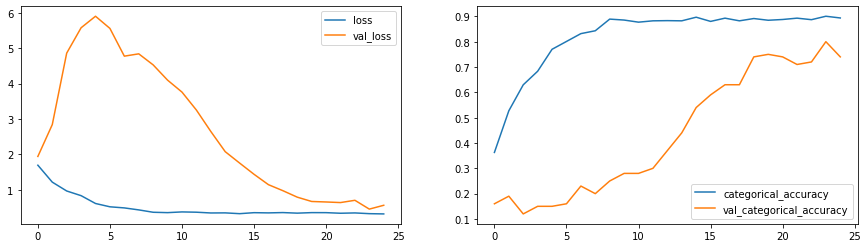

In [54]:
plot(history_model7)

###### For the above low memory foot print model the best validation accuracy of 74%

# Model 8 - reducing the number of parameters

In [55]:
class ModelConv3D8(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = 'adam' #write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())
        return model

In [58]:
conv_3d8=ModelConv3D8()
conv_3d8.initialize_path(project_folder)
conv_3d8.initialize_image_properties(image_height=64,image_width=64)
conv_3d8.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=10)
conv_3d8_model=conv_3d8.define_model(dense_neurons=64,dropout=0.25)
conv_3d8_model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_100 (Conv3D)         (None, 16, 64, 64, 8)     656       
                                                                 
 activation_100 (Activation)  (None, 16, 64, 64, 8)    0         
                                                                 
 batch_normalization_146 (Ba  (None, 16, 64, 64, 8)    32        
 tchNormalization)                                               
                                                                 
 max_pooling3d_92 (MaxPoolin  (None, 8, 32, 32, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_101 (Conv3D)         (None, 8, 32, 32, 16)     3472      
                                                                 
 activation_101 (Activation)  (None, 8, 32, 32, 16)  

In [59]:
print("Total Params:", conv_3d8_model.count_params())
history_model8=conv_3d8.train_model(conv_3d8_model,augment_data=True)

Total Params: 95781
Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 1.8550 - categorical_accuracy: 0.3386
Epoch 00001: saving model to model_init_2023-03-1415_55_42.945398/model-00001-1.85503-0.33861-1.73577-0.16000.h5
34/34 [==============================] - 74s 2s/step - loss: 1.8550 - categorical_accuracy: 0.3386 - val_loss: 1.7358 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.3744 - categorical_accuracy: 0.4789
Epoch 00002: saving model to model_init_2023-03-1415_55_42.945398/model-00002-1.37438-0.47888-2.90904-0.14000.h5
34/34 [==============================] - 74s 2s/step - loss: 1.3744 - categorical_accuracy: 0.4789 - val_loss: 2.9090 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 1.2687 - categorical_accuracy: 0.5023
Epoch 00003: saving model to model_init_2023-03-1415_55_42.945398/model-00003-1.26873-0.50226-5.09912-0.

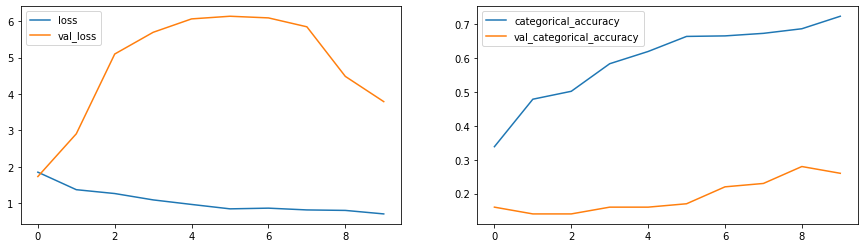

In [60]:
plot(history_model8)

###### For the above low memory foot print model the validation accuracy of 26%

# Model 9 - CNN- LSTM Model

In [61]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = 'adam' #write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())
        return model

In [62]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=64,image_width=64)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=10)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 64, 64, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 64, 64, 16)   64        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 32, 32, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 32, 32, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 32, 32, 32) 

In [63]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model9=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1002085
Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 1.3929 - categorical_accuracy: 0.3982
Epoch 00001: saving model to model_init_2023-03-1416_07_56.488975/model-00001-1.39285-0.39819-1.70930-0.21000.h5
34/34 [==============================] - 88s 3s/step - loss: 1.3929 - categorical_accuracy: 0.3982 - val_loss: 1.7093 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.1090 - categorical_accuracy: 0.5588
Epoch 00002: saving model to model_init_2023-03-1416_07_56.488975/model-00002-1.10901-0.55882-2.69355-0.15000.h5
34/34 [==============================] - 85s 3s/step - loss: 1.1090 - categorical_accuracy: 0.5588 - val_loss: 2.6935 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 0.8842 - categorical_accuracy: 0.6554
Epoch 00003: saving model to model_init_2023-03-1416_07_56.488975/model-00003-0.88422-0.65535-2.38301-

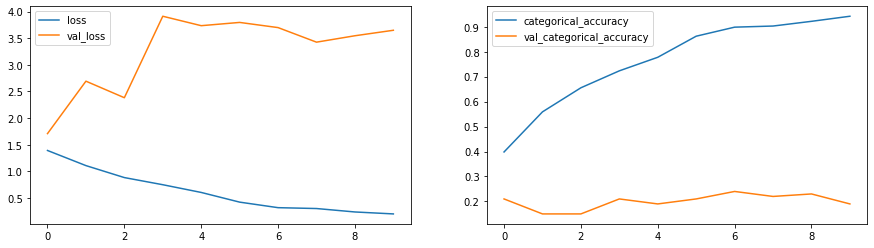

In [64]:
plot(history_model9)

##### For CNN - LSTM model we got a validation accuracy of 19%; model is overfitting.

### As we see more cases of overfitting, lets augment the data with slight rotation as well and run the same set of models again

# More Augmentation

In [65]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=64,image_width=64):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=10):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

In [66]:
#class Test(ModelBuilderMoreAugmentation):
#    def define_model(self):
#        pass

#test_generator=Test()
#test_generator.initialize_path(project_folder)
#test_generator.initialize_image_properties(image_height=64,image_width=64)
#test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

#g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
#batch_data, batch_labels=next(g)
#fig, axes = plt.subplots(nrows=1, ncols=2)
#axes[0].imshow(batch_data[0,29,:,:,:])   
#axes[1].imshow(batch_data[3,29,:,:,:])   

# Model 10 - (3,3,3) Filter & 64x64 Image resolution - similar to Model 2

In [70]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = 'adam' #write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())
        return model

In [71]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=64,image_width=64)
conv_3d10.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=10)
conv_3d10_model=conv_3d10.define_model(dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_108 (Conv3D)         (None, 20, 64, 64, 16)    1312      
                                                                 
 activation_108 (Activation)  (None, 20, 64, 64, 16)   0         
                                                                 
 batch_normalization_163 (Ba  (None, 20, 64, 64, 16)   64        
 tchNormalization)                                               
                                                                 
 max_pooling3d_100 (MaxPooli  (None, 10, 32, 32, 16)   0         
 ng3D)                                                           
                                                                 
 conv3d_109 (Conv3D)         (None, 10, 32, 32, 32)    13856     
                                                                 
 activation_109 (Activation)  (None, 10, 32, 32, 32) 

In [72]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 886469
Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 2.0612 - categorical_accuracy: 0.3250
Epoch 00001: saving model to model_init_2023-03-1416_27_24.706024/model-00001-2.06124-0.32504-2.34595-0.17000.h5
34/34 [==============================] - 94s 3s/step - loss: 2.0612 - categorical_accuracy: 0.3250 - val_loss: 2.3460 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.6221 - categorical_accuracy: 0.4140
Epoch 00002: saving model to model_init_2023-03-1416_27_24.706024/model-00002-1.62208-0.41403-3.35419-0.16000.h5
34/34 [==============================] - 91s 3s/step - loss: 1.6221 - categorical_accuracy: 0.4140 - val_loss: 3.3542 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 1.4697 - categorical_accuracy: 0.4676
Epoch 00003: saving model to model_init_2023-03-1416_27_24.706024/model-00003-1.46966-0.46757-4.97657-0

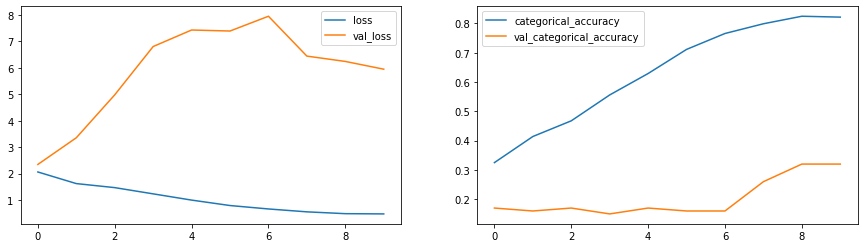

In [73]:
plot(history_model10)

# Model 11 - (2,2,2) Filter  & 64x64 Image resolution - similar to Model 3

In [74]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = 'adam' #write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())
        return model

In [75]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=64,image_width=64)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=10)
conv_3d11_model=conv_3d11.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_112 (Conv3D)         (None, 16, 64, 64, 16)    400       
                                                                 
 activation_112 (Activation)  (None, 16, 64, 64, 16)   0         
                                                                 
 batch_normalization_169 (Ba  (None, 16, 64, 64, 16)   64        
 tchNormalization)                                               
                                                                 
 max_pooling3d_104 (MaxPooli  (None, 8, 32, 32, 16)    0         
 ng3D)                                                           
                                                                 
 conv3d_113 (Conv3D)         (None, 8, 32, 32, 32)     4128      
                                                                 
 activation_113 (Activation)  (None, 8, 32, 32, 32)  

In [76]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 681269
Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 2.0481 - categorical_accuracy: 0.3499
Epoch 00001: saving model to model_init_2023-03-1416_48_04.884237/model-00001-2.04814-0.34992-2.14138-0.21000.h5
23/23 [==============================] - 75s 3s/step - loss: 2.0481 - categorical_accuracy: 0.3499 - val_loss: 2.1414 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 1.4043 - categorical_accuracy: 0.5211
Epoch 00002: saving model to model_init_2023-03-1416_48_04.884237/model-00002-1.40435-0.52112-3.24621-0.21000.h5
23/23 [==============================] - 74s 3s/step - loss: 1.4043 - categorical_accuracy: 0.5211 - val_loss: 3.2462 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/10
23/23 [==============================] - ETA: 0s - loss: 1.1727 - categorical_accuracy: 0.5965
Epoch 00003: saving model to model_init_2023-03-1416_48_04.884237/model-00003-1.17272-0.59653-4.77280-0

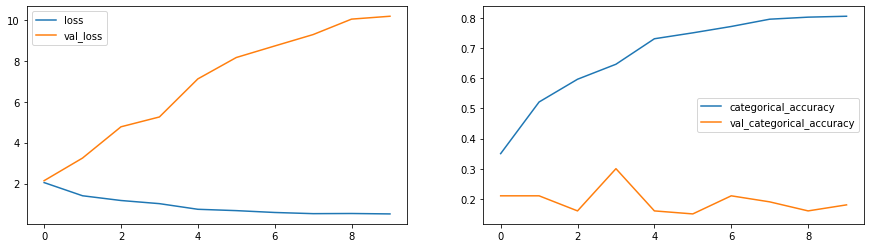

In [77]:
plot(history_model11)

# Model 12 - Adding more layers - Similar to model 4

In [78]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = 'adam' #write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())
        return model

In [79]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=64,image_width=64)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=10)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d12_model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_116 (Conv3D)         (None, 16, 64, 64, 16)    1312      
                                                                 
 activation_116 (Activation)  (None, 16, 64, 64, 16)   0         
                                                                 
 batch_normalization_175 (Ba  (None, 16, 64, 64, 16)   64        
 tchNormalization)                                               
                                                                 
 conv3d_117 (Conv3D)         (None, 16, 64, 64, 16)    6928      
                                                                 
 activation_117 (Activation)  (None, 16, 64, 64, 16)   0         
                                                                 
 batch_normalization_176 (Ba  (None, 16, 64, 64, 16)   64        
 tchNormalization)                                   

In [80]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

Total Params: 1475189
Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 2.1534 - categorical_accuracy: 0.3250
Epoch 00001: saving model to model_init_2023-03-1417_00_43.913641/model-00001-2.15343-0.32504-2.09899-0.34000.h5
34/34 [==============================] - 76s 2s/step - loss: 2.1534 - categorical_accuracy: 0.3250 - val_loss: 2.0990 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.7255 - categorical_accuracy: 0.3914
Epoch 00002: saving model to model_init_2023-03-1417_00_43.913641/model-00002-1.72548-0.39140-1.66032-0.25000.h5
34/34 [==============================] - 73s 2s/step - loss: 1.7255 - categorical_accuracy: 0.3914 - val_loss: 1.6603 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 1.4645 - categorical_accuracy: 0.4819
Epoch 00003: saving model to model_init_2023-03-1417_00_43.913641/model-00003-1.46453-0.48190-1.83033-

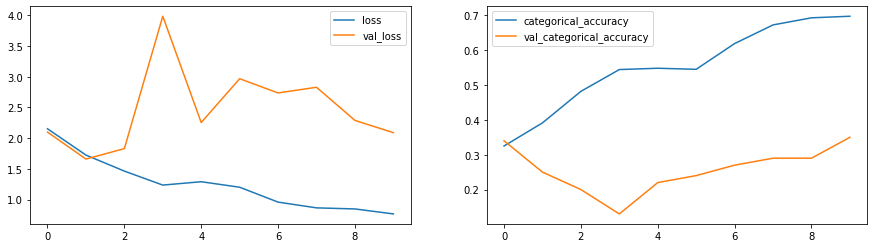

In [81]:
plot(history_model12)

# Model 13 - Adding dropouts - Similar to Model 5

In [82]:
class ModelConv3D13(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = 'adam' #write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())
        return model

In [83]:
conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=64,image_width=64)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=10)
conv_3d13_model=conv_3d13.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d13_model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_124 (Conv3D)         (None, 16, 64, 64, 16)    1312      
                                                                 
 activation_124 (Activation)  (None, 16, 64, 64, 16)   0         
                                                                 
 batch_normalization_185 (Ba  (None, 16, 64, 64, 16)   64        
 tchNormalization)                                               
                                                                 
 conv3d_125 (Conv3D)         (None, 16, 64, 64, 16)    6928      
                                                                 
 activation_125 (Activation)  (None, 16, 64, 64, 16)   0         
                                                                 
 batch_normalization_186 (Ba  (None, 16, 64, 64, 16)   64        
 tchNormalization)                                   

In [84]:
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

Total Params: 1475189
Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 1.9680 - categorical_accuracy: 0.2986
Epoch 00001: saving model to model_init_2023-03-1417_13_41.543869/model-00001-1.96802-0.29864-1.79151-0.27000.h5
34/34 [==============================] - 76s 2s/step - loss: 1.9680 - categorical_accuracy: 0.2986 - val_loss: 1.7915 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/10
33/34 [============================>.] - ETA: 2s - loss: 1.6293 - categorical_accuracy: 0.3795
Epoch 00002: saving model to model_init_2023-03-1417_13_41.543869/model-00002-1.63282-0.37934-2.32992-0.15000.h5
34/34 [==============================] - 74s 2s/step - loss: 1.6328 - categorical_accuracy: 0.3793 - val_loss: 2.3299 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 1.4146 - categorical_accuracy: 0.4336
Epoch 00003: saving model to model_init_2023-03-1417_13_41.543869/model-00003-1.41458-0.43363-1.99969-

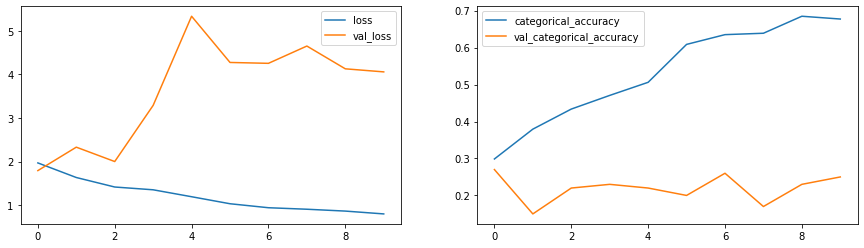

In [85]:
plot(history_model13)

# Model 14 - reducing network parameters - Similar to Model 6

In [86]:
class ModelConv3D14(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = 'adam' #write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())
        return model

In [87]:
conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=64,image_width=64)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=10)
conv_3d14_model=conv_3d14.define_model(dense_neurons=128,dropout=0.25)
conv_3d14_model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_132 (Conv3D)         (None, 16, 64, 64, 16)    1312      
                                                                 
 activation_132 (Activation)  (None, 16, 64, 64, 16)   0         
                                                                 
 batch_normalization_195 (Ba  (None, 16, 64, 64, 16)   64        
 tchNormalization)                                               
                                                                 
 max_pooling3d_116 (MaxPooli  (None, 8, 32, 32, 16)    0         
 ng3D)                                                           
                                                                 
 conv3d_133 (Conv3D)         (None, 8, 32, 32, 32)     4128      
                                                                 
 activation_133 (Activation)  (None, 8, 32, 32, 32)  

In [88]:
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

Total Params: 368965
Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 1.5669 - categorical_accuracy: 0.4374
Epoch 00001: saving model to model_init_2023-03-1417_26_38.563088/model-00001-1.56688-0.43741-2.45075-0.16000.h5
34/34 [==============================] - 75s 2s/step - loss: 1.5669 - categorical_accuracy: 0.4374 - val_loss: 2.4507 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.0339 - categorical_accuracy: 0.5920
Epoch 00002: saving model to model_init_2023-03-1417_26_38.563088/model-00002-1.03392-0.59201-5.08654-0.15000.h5
34/34 [==============================] - 74s 2s/step - loss: 1.0339 - categorical_accuracy: 0.5920 - val_loss: 5.0865 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 0.8180 - categorical_accuracy: 0.6802
Epoch 00003: saving model to model_init_2023-03-1417_26_38.563088/model-00003-0.81803-0.68024-7.60209-0

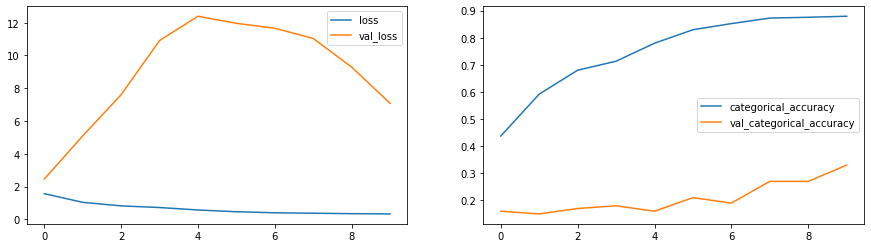

In [89]:
plot(history_model14)

# Model 15 - reducing network parameters - Similar to model 7

In [90]:
class ModelConv3D15(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = 'adam' #write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())
        return model

In [91]:
conv_3d15=ModelConv3D15()
conv_3d15.initialize_path(project_folder)
conv_3d15.initialize_image_properties(image_height=64,image_width=64)
conv_3d15.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=10)
conv_3d15_model=conv_3d15.define_model(dense_neurons=64,dropout=0.25)
conv_3d15_model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_136 (Conv3D)         (None, 16, 64, 64, 16)    1312      
                                                                 
 activation_136 (Activation)  (None, 16, 64, 64, 16)   0         
                                                                 
 batch_normalization_201 (Ba  (None, 16, 64, 64, 16)   64        
 tchNormalization)                                               
                                                                 
 max_pooling3d_120 (MaxPooli  (None, 8, 32, 32, 16)    0         
 ng3D)                                                           
                                                                 
 conv3d_137 (Conv3D)         (None, 8, 32, 32, 32)     13856     
                                                                 
 activation_137 (Activation)  (None, 8, 32, 32, 32)  

In [92]:
print("Total Params:", conv_3d15_model.count_params())
history_model15=conv_3d15.train_model(conv_3d15_model,augment_data=True)

Total Params: 234373
Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 1.6765 - categorical_accuracy: 0.3499
Epoch 00001: saving model to model_init_2023-03-1417_40_48.099624/model-00001-1.67651-0.34992-1.86866-0.16000.h5
34/34 [==============================] - 76s 2s/step - loss: 1.6765 - categorical_accuracy: 0.3499 - val_loss: 1.8687 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.2652 - categorical_accuracy: 0.5053
Epoch 00002: saving model to model_init_2023-03-1417_40_48.099624/model-00002-1.26520-0.50528-2.81778-0.17000.h5
34/34 [==============================] - 74s 2s/step - loss: 1.2652 - categorical_accuracy: 0.5053 - val_loss: 2.8178 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 1.1236 - categorical_accuracy: 0.5618
Epoch 00003: saving model to model_init_2023-03-1417_40_48.099624/model-00003-1.12360-0.56184-3.89108-0

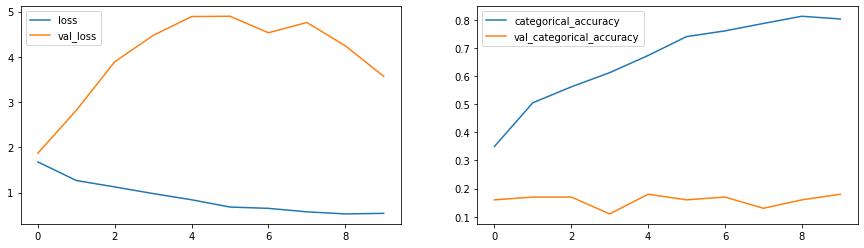

In [93]:
plot(history_model15)

# Model 16 - reducing network parameters - Similar to Model 8

In [94]:
class ModelConv3D16(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = 'adam' #write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())
        return model

In [95]:
conv_3d16=ModelConv3D16()
conv_3d16.initialize_path(project_folder)
conv_3d16.initialize_image_properties(image_height=64,image_width=64)
conv_3d16.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=10)
conv_3d16_model=conv_3d16.define_model(dense_neurons=64,dropout=0.25)
conv_3d16_model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_140 (Conv3D)         (None, 16, 64, 64, 8)     656       
                                                                 
 activation_140 (Activation)  (None, 16, 64, 64, 8)    0         
                                                                 
 batch_normalization_207 (Ba  (None, 16, 64, 64, 8)    32        
 tchNormalization)                                               
                                                                 
 max_pooling3d_124 (MaxPooli  (None, 8, 32, 32, 8)     0         
 ng3D)                                                           
                                                                 
 conv3d_141 (Conv3D)         (None, 8, 32, 32, 16)     3472      
                                                                 
 activation_141 (Activation)  (None, 8, 32, 32, 16)  

In [96]:
print("Total Params:", conv_3d16_model.count_params())
history_model16=conv_3d16.train_model(conv_3d16_model,augment_data=True)

Total Params: 95781
Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 1.8660 - categorical_accuracy: 0.3190
Epoch 00001: saving model to model_init_2023-03-1417_53_20.973134/model-00001-1.86596-0.31900-1.73642-0.21000.h5
34/34 [==============================] - 75s 2s/step - loss: 1.8660 - categorical_accuracy: 0.3190 - val_loss: 1.7364 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.3490 - categorical_accuracy: 0.4706
Epoch 00002: saving model to model_init_2023-03-1417_53_20.973134/model-00002-1.34905-0.47059-2.19508-0.22000.h5
34/34 [==============================] - 74s 2s/step - loss: 1.3490 - categorical_accuracy: 0.4706 - val_loss: 2.1951 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 1.1576 - categorical_accuracy: 0.5219
Epoch 00003: saving model to model_init_2023-03-1417_53_20.973134/model-00003-1.15759-0.52187-3.27976-0.

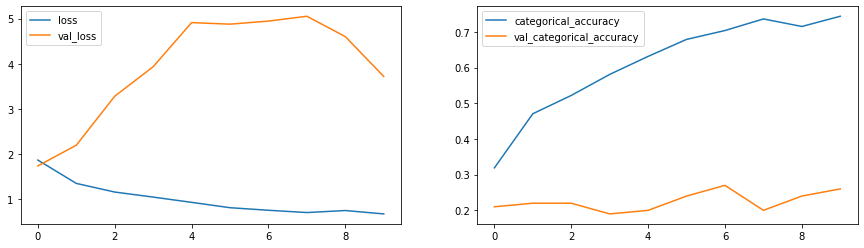

In [97]:
plot(history_model16)

# Model 17 - CNN LSTM with GRU - Similar to Model 9

In [98]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = 'adam' #write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())
        return model

In [99]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=64,image_width=64)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=10)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 18, 64, 64, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 18, 64, 64, 16)   64        
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 18, 32, 32, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 18, 32, 32, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 18, 32, 32, 32) 

In [100]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model17=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 951909
Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 1.4692 - categorical_accuracy: 0.3937
Epoch 00001: saving model to model_init_2023-03-1418_06_04.107480/model-00001-1.46916-0.39367-1.93583-0.16000.h5
34/34 [==============================] - 85s 3s/step - loss: 1.4692 - categorical_accuracy: 0.3937 - val_loss: 1.9358 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.0152 - categorical_accuracy: 0.6078
Epoch 00002: saving model to model_init_2023-03-1418_06_04.107480/model-00002-1.01518-0.60784-2.49265-0.16000.h5
34/34 [==============================] - 82s 2s/step - loss: 1.0152 - categorical_accuracy: 0.6078 - val_loss: 2.4926 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 0.8151 - categorical_accuracy: 0.7021
Epoch 00003: saving model to model_init_2023-03-1418_06_04.107480/model-00003-0.81514-0.70211-2.64883-0

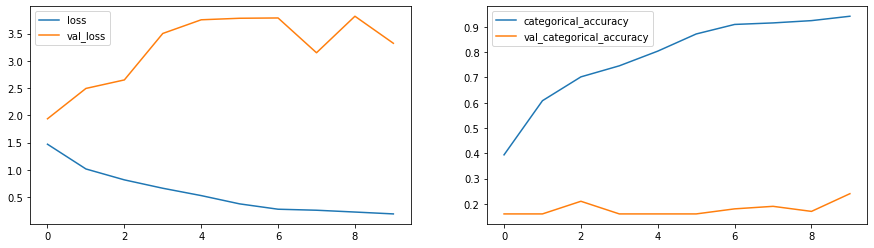

In [101]:
plot(history_model17)

### It's overfitting.

# Model 18 - Transfer Learning

In [102]:
from keras.applications import mobilenet

In [103]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = 'adam' #write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())
        return model

17235968/17225924 [==============================] - 1s 0us/step


In [104]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=64,image_width=64)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=10)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_29 (TimeDi  (None, 16, 2, 2, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 16, 2, 2, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_32 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 128)             

In [105]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model18=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Total Params: 3840453
Epoch 1/10
133/133 [==============================] - ETA: 0s - loss: 1.4622 - categorical_accuracy: 0.3635
Epoch 00001: saving model to model_init_2023-03-1418_21_32.509297/model-00001-1.46215-0.36350-1.12396-0.59000.h5
133/133 [==============================] - 84s 607ms/step - loss: 1.4622 - categorical_accuracy: 0.3635 - val_loss: 1.1240 - val_categorical_accuracy: 0.5900 - lr: 0.0010
Epoch 2/10
133/133 [==============================] - ETA: 0s - loss: 1.0006 - categorical_accuracy: 0.6048
Epoch 00002: saving model to model_init_2023-03-1418_21_32.509297/model-00002-1.00060-0.60483-0.92109-0.69000.h5
133/133 [==============================] - 77s 584ms/step - loss: 1.0006 - categorical_accuracy: 0.6048 - val_loss: 0.9211 - val_categorical_accuracy: 0.6900 - lr: 0.0010
Epoch 3/10
133/133 [==============================] - ETA: 0s - loss: 0.8053 - categorical_accuracy: 0.7006
Epoch 00003: saving model to model_init_2023-03-1418_21_32.509297/model-00003-0.80528-

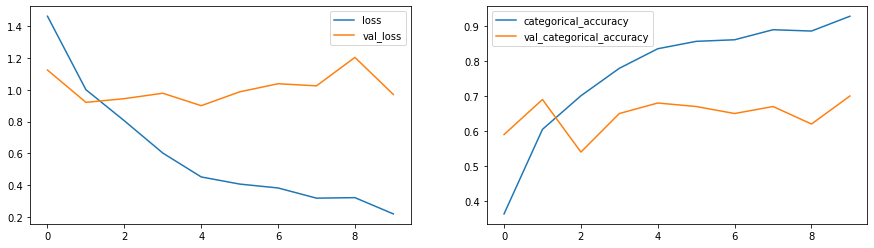

In [106]:
plot(history_model18)

##### We are not training the mobilenet weights and we see validation accuracy is 70%.  Let's train them as well and observe if there is performance improvement

# Model 19 - Transfer Learning with GRU and training all weights

In [107]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = 'adam' #write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())
        return model

In [108]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=64,image_width=64)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=10)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_33 (TimeDi  (None, 16, 2, 2, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 16, 2, 2, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 128)             

In [109]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model19=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Epoch 1/10
133/133 [==============================] - ETA: 0s - loss: 1.2103 - categorical_accuracy: 0.5219
Epoch 00001: saving model to model_init_2023-03-1418_37_01.261627/model-00001-1.21027-0.52187-1.08550-0.62000.h5
133/133 [==============================] - 80s 576ms/step - loss: 1.2103 - categorical_accuracy: 0.5219 - val_loss: 1.0855 - val_categorical_accuracy: 0.6200 - lr: 0.0010
Epoch 2/10
133/133 [==============================] - ETA: 0s - loss: 0.6928 - categorical_accuracy: 0.7602
Epoch 00002: saving model to model_init_2023-03-1418_37_01.261627/model-00002-0.69275-0.76018-0.57039-0.77000.h5
133/133 [==============================] - 78s 593ms/step - loss: 0.6928 - categorical_accuracy: 0.7602 - val_loss: 0.5704 - val_categorical_accuracy: 0.7700 - lr: 0.0010
Epoch 3/10
133/133 [==============================] - ETA: 0s - loss: 0.5605 - categorical_accuracy: 0.8107
Epoch 00003: saving model to model_init_2023-03-1418_37_01.261627/model-00003-0.56052-

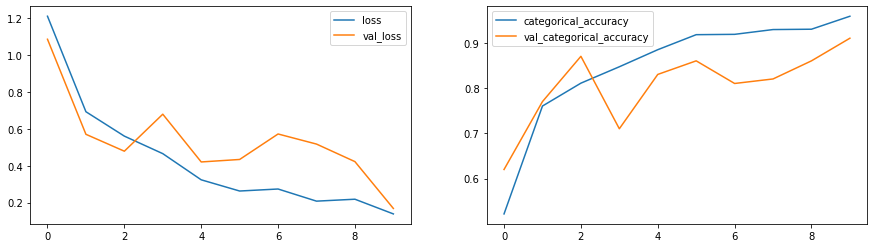

In [110]:
plot(history_model19)

# Consolidated Final Models

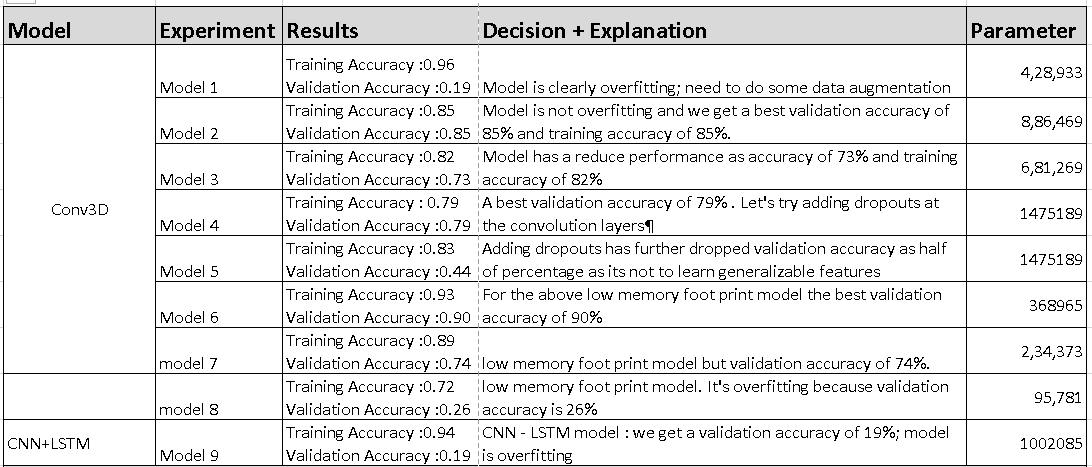
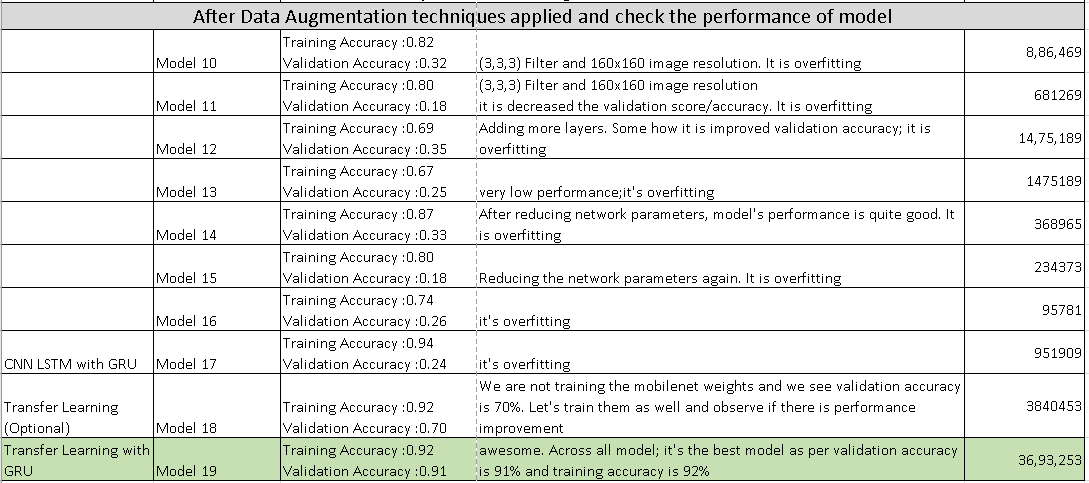

# Loading model & Testing

In [111]:
import time
from keras.models import load_model
model = load_model('model_init_2023-03-1418_37_01.261627/model-00010-0.13891-0.95852-0.16848-0.91000.h5')

In [115]:
test_generator=ModelConv3D10()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=64,image_width=64)
test_generator.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [116]:
batch_labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [117]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[1 2 1 2 2]


## Observation:
- `Transfer Learning with GRU` is the best model for `Gesture Recognization` with `data augmentation`.Training accuracy is `92%` and validation accuracy is `91%` with parameters of `3693253`.